In [1]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import string
from bs4 import BeautifulSoup
import re
from imblearn.over_sampling import SMOTE
import nlpaug.augmenter.word as naw
import random

2023-09-23 16:28:00.975429: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-23 16:28:01.702419: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/roronoa/.conda/envs/tf/lib/python3.7/site-packages/nvidia/cudnn/lib:/home/roronoa/.conda/envs/tf/lib/:
2023-09-23 16:28:01.702512: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/roronoa/.conda/

In [2]:
df = pd.read_csv("../../Data.csv")

In [3]:
df.head()

,text,subject
0,Donald Trump just couldn t wish all Americans ...,News
1,House Intelligence Committee Chairman Devin Nu...,News
2,"On Friday, it was revealed that former Milwauk...",News
3,"On Christmas day, Donald Trump announced that ...",News
4,Pope Francis used his annual Christmas Day mes...,News


In [4]:
df['text'].iloc[1]

'House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained by the New York Times.Former Trump campaign adviser George Papadopoulos was drunk in a wine bar when he revealed knowledge of Russian opposition research on Hillary Clinton.On top of that, Papadopoulos wasn t just a covfefe boy for Trump, as his administration has alleged. He had a much larger role, but none so damning as being a drunken fool in a wine bar. Coffee boys  don t help to arrange a New York meeting between Trump and President Abdel Fattah el-Sisi of Egypt two months before the election. It was known before that the former aide set up meetings with world leaders for Trump, but team Tr

In [5]:
df.describe(include='all')


,text,subject
count,44919,44898
unique,38657,19
top,,politicsNews
freq,627,11272


In [6]:
df.shape

(44919, 2)

In [7]:
df['subject'].value_counts()

politicsNews                                                                                                                                                                                                                                                                                    11272
worldnews                                                                                                                                                                                                                                                                                       10145
News                                                                                                                                                                                                                                                                                             9050
politics                                                                                                              

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44919 entries, 0 to 44918
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     44919 non-null  object
 1   subject  44898 non-null  object
dtypes: object(2)
memory usage: 702.0+ KB


In [9]:
df.isnull().sum()

text        0
subject    21
dtype: int64

In [10]:
df = df.dropna()

In [11]:
df.duplicated().sum()

865

In [12]:
df = df.drop_duplicates(keep = "first")

In [13]:
categories =['politicsNews','worldnews','News','politics','left-news','Government News','US_News','Middle-east']

In [14]:
df = df[df['subject'].isin(categories)]

In [18]:
df['subject'].value_counts()


politics           17636
worldnews           9989
News                9050
left-news           4303
Government News     1499
US_News              775
Name: subject, dtype: int64

In [19]:
df['subject'] = df['subject'].replace({'politicsNews': 'politics'})

In [20]:
df['subject'].value_counts()

politics           17636
worldnews           9989
News                9050
left-news           4303
Government News     1499
US_News              775
Name: subject, dtype: int64

(array([ 9050.,     0., 17636.,     0.,  1499.,     0.,  4303.,     0.,
          775.,  9989.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

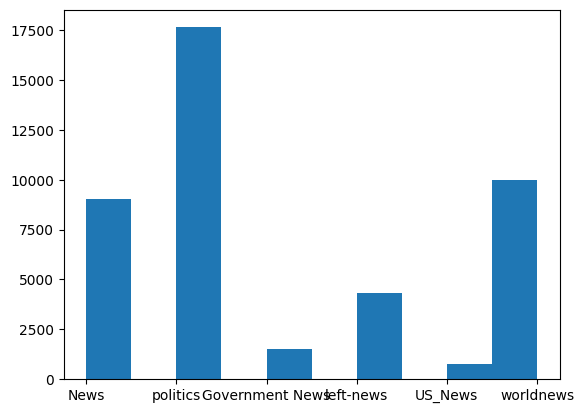

In [21]:
plt.hist(df['subject'])

In [22]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['subject']=encoder.fit_transform(df['subject'])

# Pre-Processing Starts



In [23]:
def remove_urls(text):
    # Define a regular expression pattern to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    return re.sub(url_pattern, '', text)

df['text']= df['text'].apply(remove_urls)

In [24]:
df['text'].iloc[9072]

'Just what we need another Trump-bashing RINO. Carpetbagger Mitt Romney is trying yet another run at getting elected for something. His track record isn t so great but he just announced his run for Senator of Utah. His first ad released this morning takes a swipe at President Trump s immigration policy to put Americans first. Notice how he says  immigrants . Well, we welcome LEGAL IMMIGRANTS to this country all the time. It s the ILLEGALS who have broken the law that we don t welcome. Romney used the oldest trick in the political playbook to conflate legal immigrants with illegal aliens. He should just run as a Democrat Former Massachusetts governor and one-time Republican presidential candidate Mitt Romney is running for the U.S. Senate in Utah.  pic.twitter.com/28eZ3YfBzt  ABC News (@ABC) February 16, 2018President Trump doesn t need another RINO voting against him '

In [25]:
#Removing HTML tags from the whole dataset
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

df['text'] = df['text'].apply(remove_html_tags)

/home/roronoa/.conda/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
#Noticed, there were some gaps in some urls which led to some texts like 'pic.twitter.com/28eZ3YfBzt like seen above'
#Creating a function to remove stuff like this
# A lot of data points have pattern like '(@.......)'
#Some data have Via: , after which source of news is written, which is not necessary for the model
def remove_patterns(text):
    # Define regular expression patterns to match the specified text patterns
    url_pattern = r'pic\.twitter\.com/\w+'
    mention_pattern = r'@\w+'
    read_pattern = r'(READ MORE|Read more).*$'
    via_pattern = r'(VIA:|via:|Via:).*'
    watch_pattern = r'Watch:.*'
    
    # Remove both patterns from the text
    text = re.sub(url_pattern, '', text)
    text = re.sub(mention_pattern, '', text)
    text = re.sub(read_pattern , '', text)
    text = re.sub(via_pattern , '', text)
    text = re.sub(watch_pattern , '', text)
    
    
    return text

df['text']=df['text'].apply(remove_patterns)

In [27]:
df['text'].iloc[9072]

'Just what we need another Trump-bashing RINO. Carpetbagger Mitt Romney is trying yet another run at getting elected for something. His track record isn t so great but he just announced his run for Senator of Utah. His first ad released this morning takes a swipe at President Trump s immigration policy to put Americans first. Notice how he says  immigrants . Well, we welcome LEGAL IMMIGRANTS to this country all the time. It s the ILLEGALS who have broken the law that we don t welcome. Romney used the oldest trick in the political playbook to conflate legal immigrants with illegal aliens. He should just run as a Democrat Former Massachusetts governor and one-time Republican presidential candidate Mitt Romney is running for the U.S. Senate in Utah.    ABC News () February 16, 2018President Trump doesn t need another RINO voting against him '

In [28]:
# Since there was no space after each full stop, NLTK sent_tokenize considered 2 sentences as 1
def insert_space_after_full_stop(text):
    return text.replace('.', '. ')
df['text'] = df['text'].apply(insert_space_after_full_stop)

In [29]:
#The last sentence of 'News' Class is of the format "Photo by..." OR "Featured by...."
def remove_last_sentence(text):
    sentences = nltk.sent_tokenize(text)
    
    
    if len(sentences) > 1:
        return ' '.join(sentences[:-1])
    else:
        return text



# Apply the function to the specified class
df.loc[df['subject'] == 'News','text'] = df[df['subject'] == 'News']['text'].apply(remove_last_sentence)


In [30]:
df['text'].iloc[9072]

'Just what we need another Trump-bashing RINO.  Carpetbagger Mitt Romney is trying yet another run at getting elected for something.  His track record isn t so great but he just announced his run for Senator of Utah.  His first ad released this morning takes a swipe at President Trump s immigration policy to put Americans first.  Notice how he says  immigrants .  Well, we welcome LEGAL IMMIGRANTS to this country all the time.  It s the ILLEGALS who have broken the law that we don t welcome.  Romney used the oldest trick in the political playbook to conflate legal immigrants with illegal aliens.  He should just run as a Democrat Former Massachusetts governor and one-time Republican presidential candidate Mitt Romney is running for the U. S.  Senate in Utah.     ABC News () February 16, 2018President Trump doesn t need another RINO voting against him '

In [31]:
df.head()

,text,subject
0,Donald Trump just couldn t wish all Americans ...,1
1,House Intelligence Committee Chairman Devin Nu...,1
2,"On Friday, it was revealed that former Milwauk...",1
3,"On Christmas day, Donald Trump announced that ...",1
4,Pope Francis used his annual Christmas Day mes...,1


In [34]:
df['subject'].value_counts()

4    17636
5     9989
1     9050
3     4303
0     1499
2      775
Name: subject, dtype: int64

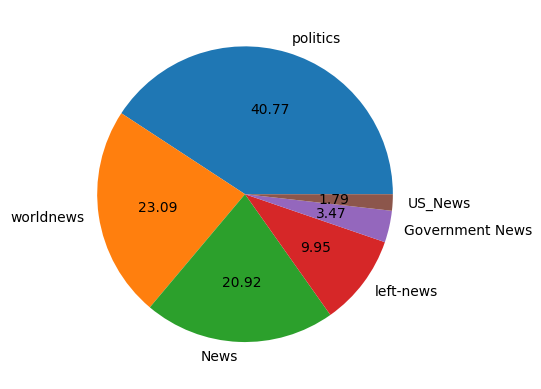

In [35]:

plt.pie(df['subject'].value_counts(),labels = ['politics','worldnews','News','left-news','Government News',     
'US_News'], autopct="%0.2f")
plt.show()

In [36]:
def lemmatization(text):
    lm= WordNetLemmatizer()
    text = ' '.join([lm.lemmatize(word, pos='v') for word in text.split()])
    return text

In [37]:
df['text']= df['text'].apply(lemmatization)
df.head()

,text,subject
0,Donald Trump just couldn t wish all Americans ...,1
1,House Intelligence Committee Chairman Devin Nu...,1
2,"On Friday, it be reveal that former Milwaukee ...",1
3,"On Christmas day, Donald Trump announce that h...",1
4,Pope Francis use his annual Christmas Day mess...,1


In [38]:
ps = PorterStemmer();
def text_transform(text):
    text= text.lower()
    text = nltk.word_tokenize(text)
    y=[]
    for i in text:
        if i.isalnum():
            y.append(i)
    
    text = y[:]
    y.clear()
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
    text = y[:]
    y.clear()
    for i in text:
        y.append(ps.stem(i))
        
    
    return " ".join(y)

In [39]:
text_transform("Today we are going to analyse different text classification algorithms")

'today go analys differ text classif algorithm'

In [40]:
df['transformed text']=df['text'].apply(text_transform)

In [41]:
df.head()

,text,subject,transformed text
0,Donald Trump just couldn t wish all Americans ...,1,donald trump wish american happi new year leav...
1,House Intelligence Committee Chairman Devin Nu...,1,hous intellig committe chairman devin nune go ...
2,"On Friday, it be reveal that former Milwaukee ...",1,friday reveal former milwauke sheriff david cl...
3,"On Christmas day, Donald Trump announce that h...",1,christma day donald trump announc would back w...
4,Pope Francis use his annual Christmas Day mess...,1,pope franci use annual christma day messag reb...


In [ ]:
from wordcloud import WordCloud
wc=WordCloud(width=500,height=500,min_font_size=10,background_color='black')

In [ ]:
politics_wc = wc.generate(df[df['subject']==4]['transformed text'].str.cat(sep=" "))



In [33]:
plt.imshow(politics_wc)

NameError: name 'politics_wc' is not defined

In [42]:
worldnews_wc = wc.generate(df[df['subject']==5]['transformed text'].str.cat(sep=" "))


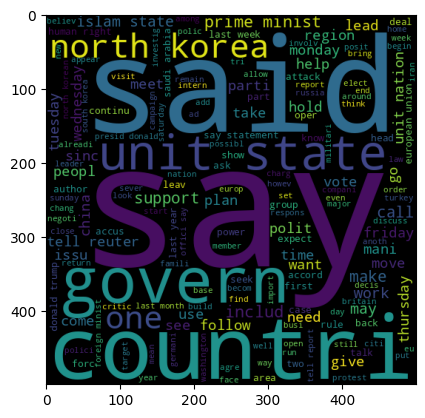

In [43]:
plt.imshow(worldnews_wc)

In [44]:
News_wc = wc.generate(df[df['subject']==1]['transformed text'].str.cat(sep=" "))


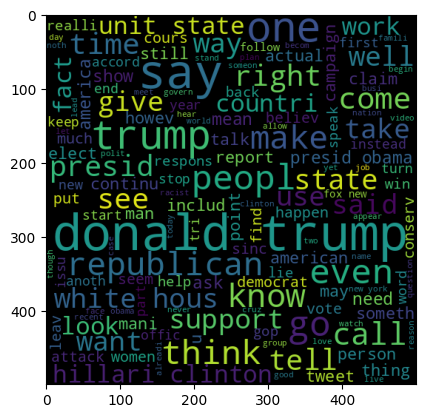

In [45]:
plt.imshow(News_wc)

In [46]:
leftnews_wc = wc.generate(df[df['subject']==3]['transformed text'].str.cat(sep=" "))


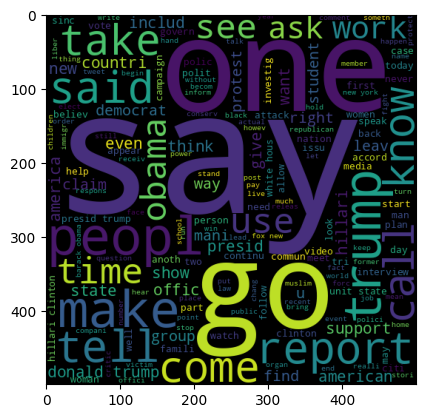

In [47]:
plt.imshow(leftnews_wc)

In [48]:
GovernmentNews_wc = wc.generate(df[df['subject']==0]['transformed text'].str.cat(sep=" "))

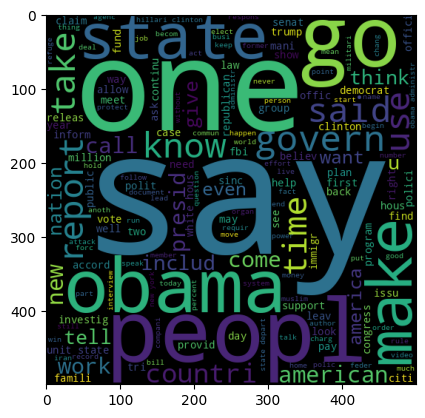

In [49]:
plt.imshow(GovernmentNews_wc )

In [50]:
US_News_wc = wc.generate(df[df['subject']==2]['transformed text'].str.cat(sep=" "))

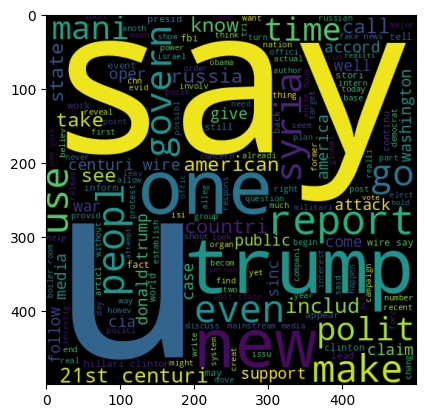

In [51]:
plt.imshow(US_News_wc )

# Cleaning and Preprocessing is done

In [45]:
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

In [46]:
df['transformed text'] = df['transformed text'].apply(remove_numbers)

In [52]:
df = df[['subject','transformed text']]

In [53]:
df.head()

,subject,transformed text
0,1,donald trump wish american happi new year leav...
1,1,hous intellig committe chairman devin nune go ...
2,1,friday reveal former milwauke sheriff david cl...
3,1,christma day donald trump announc would back w...
4,1,pope franci use annual christma day messag reb...


# Creating new file with cleaned text for making future models

In [54]:
df.to_csv('data/CleanedData.csv', index = False)


In [55]:
df2 = pd.read_csv('data/CleanedData.csv')

In [56]:
df2.isnull().sum()

subject               0
transformed text    127
dtype: int64

In [57]:
df2.shape

(43252, 2)

In [58]:
df2= df2.dropna()

In [59]:
df2.to_csv('data/CleanedData.csv', index = False)